# Classification Samples Observations

## Setup

### Library Imports

In [1]:
import os, re
from pathlib import Path

### Path Dictionary

In [2]:
path = {'root': Path(os.getcwd()).parent}

path['data'] = Path(path['root'], 'classification', 'old', 'data')
path['samples'] = sorted(path['data'].glob('*.parquet'))#[7:8]
path['nom_path'] = Path(path['root'], 'vector_data', 'nomenclature', 'nomenclature_revue_v1.csv')
path

{'root': PosixPath('/work/OT/biomass/tharen/forest-mapping'),
 'data': PosixPath('/work/OT/biomass/tharen/forest-mapping/classification/old/data'),
 'samples': [PosixPath('/work/OT/biomass/tharen/forest-mapping/classification/old/data/exhaustion_20.parquet'),
  PosixPath('/work/OT/biomass/tharen/forest-mapping/classification/old/data/samples_100_periodic.parquet'),
  PosixPath('/work/OT/biomass/tharen/forest-mapping/classification/old/data/samples_100_random.parquet'),
  PosixPath('/work/OT/biomass/tharen/forest-mapping/classification/old/data/samples_10_periodic.parquet'),
  PosixPath('/work/OT/biomass/tharen/forest-mapping/classification/old/data/samples_10_random.parquet'),
  PosixPath('/work/OT/biomass/tharen/forest-mapping/classification/old/data/samples_15_periodic.parquet'),
  PosixPath('/work/OT/biomass/tharen/forest-mapping/classification/old/data/samples_15_random.parquet'),
  PosixPath('/work/OT/biomass/tharen/forest-mapping/classification/old/data/samples_1_periodic.parquet

In [4]:
import pandas as pd
nompd = pd.read_csv(path['nom_path'], sep=';')

remove = [14, 15]
codes = nompd[nompd.consid==1 & ~nompd.CODE_merge.isin(remove)][['CODE_merge', 'Name_merge', 'Description_en']]
codes['Description_en'] = codes.groupby(['CODE_merge', 'Name_merge'])['Description_en'].transform(lambda x: ', '.join(x))
codes = codes.drop_duplicates()

# Manually edit descriptions
codes.loc[18, 'Description_en'] = 'Larix decidua and Mixed coniferous forest'
codes.loc[23, 'Description_en'] = 'Mix of deciduous and coniferous'

codes

CODE_merge Name_merge                                   Description_en
2            3        CHE                                   Deciduous oaks
3            9     FF_div    Evergreen oaks, Beech, Mixed deciduous forest
5            6        CHT                                        Chessnuts
6            7        ROB                             Robinia pseudoacacia
10          11         PM                                    Maritime pine
11          12         PS                                       Scots pine
12          17        PIN  Pinus nigra, Other pure pine, Mixed pine forest
13          17         PH                                 Pinus halepensis
14          17         PC                  Pinus uncinata and pinus cembra
17          18      SP_EP                                    Fir or Spruce
18          23     FC_div        Larix decidua and Mixed coniferous forest
19          20        DOU                                      Douglas fir
23          25      F_mix                  Mix of deciduous and coniferous
29          30        PEU                               Populus plantation

In [5]:
prefix = 'code_'

nomenclature = {}
nomenclature['codes'] = dict(zip([f'{prefix}{code}' for code in codes.CODE_merge], codes.Name_merge))
nomenclature['abbrv'] = dict(zip(codes.Name_merge, codes.Description_en))
nomenclature

{'codes': {'code_3': 'CHE',
  'code_9': 'FF_div',
  'code_6': 'CHT',
  'code_7': 'ROB',
  'code_11': 'PM',
  'code_12': 'PS',
  'code_17': 'PC',
  'code_18': 'SP_EP',
  'code_23': 'FC_div',
  'code_20': 'DOU',
  'code_25': 'F_mix',
  'code_30': 'PEU'},
 'abbrv': {'CHE': 'Deciduous oaks',
  'FF_div': 'Evergreen oaks, Beech, Mixed deciduous forest',
  'CHT': 'Chessnuts',
  'ROB': 'Robinia pseudoacacia',
  'PM': 'Maritime pine',
  'PS': 'Scots pine',
  'PIN': 'Pinus nigra, Other pure pine, Mixed pine forest',
  'PH': 'Pinus halepensis',
  'PC': 'Pinus uncinata and pinus cembra',
  'SP_EP': 'Fir or Spruce',
  'FC_div': 'Larix decidua and Mixed coniferous forest',
  'DOU': 'Douglas fir',
  'F_mix': 'Mix of deciduous and coniferous',
  'PEU': 'Populus plantation'}}

## Setup Pipeline

In [6]:
dict(enumerate(path['samples']))

{0: PosixPath('/work/OT/biomass/tharen/forest-mapping/classification/old/data/exhaustion_20.parquet'),
 1: PosixPath('/work/OT/biomass/tharen/forest-mapping/classification/old/data/samples_100_periodic.parquet'),
 2: PosixPath('/work/OT/biomass/tharen/forest-mapping/classification/old/data/samples_100_random.parquet'),
 3: PosixPath('/work/OT/biomass/tharen/forest-mapping/classification/old/data/samples_10_periodic.parquet'),
 4: PosixPath('/work/OT/biomass/tharen/forest-mapping/classification/old/data/samples_10_random.parquet'),
 5: PosixPath('/work/OT/biomass/tharen/forest-mapping/classification/old/data/samples_15_periodic.parquet'),
 6: PosixPath('/work/OT/biomass/tharen/forest-mapping/classification/old/data/samples_15_random.parquet'),
 7: PosixPath('/work/OT/biomass/tharen/forest-mapping/classification/old/data/samples_1_periodic.parquet'),
 8: PosixPath('/work/OT/biomass/tharen/forest-mapping/classification/old/data/samples_1_random.parquet'),
 9: PosixPath('/work/OT/biomass/t

In [7]:
from classification import Classification, ConfusionMatrix

def evaluate_sample(sample, nomenclature, prefix='code'):
    cl = Classification()
    
    print(f'Evaluating {sample.name}...')
    featuresdf = cl.load_features(sample)
    splits, featcols = cl.split_features(featuresdf, prefix=prefix)
    model, score = cl.evaluate_model(cl.get_model(), *splits)
    
    columns, labels, predictions = cl.model_behaviour(model, splits)
    report, true_matrix, pred_matrix = cl.classification_metrics(columns, labels, predictions, 
                                                              splits, score)
    
    cm_title = sample.stem.title().replace('_', ' ')+' Confusion Matrix'
    cm_filename = sample.stem.replace('samples', 'confmat')
    cm_path = Path(sample.parent.parent, 'matrices', f'{cm_filename}.svg')
    cm = ConfusionMatrix(columns, nomenclature, report, true_matrix, pred_matrix, 
                         cm_path, title=cm_title, prefix=f'{prefix}_')
    
    return report, true_matrix, pred_matrix, cm

## Sample Imbalance

In [8]:
def evaluate_sample_imbalance(sample, nomenclature, prefix='code', step=5):
    cl = Classification()
    
    print(f'Loading {sample.name}...\n')
    featuresdf = cl.load_features(sample)
    
    for i, idf in cl.iterate_sample_imbalance(featuresdf, step=step):
        print(f'Evaluating an imbalance of {i}...')
    
        splits, featcols = cl.split_features(idf, prefix=prefix)    
        model, score = cl.evaluate_model(cl.get_model(), *splits)

        columns, labels, predictions = cl.model_behaviour(model, splits)
        report, true_matrix, pred_matrix = cl.classification_metrics(columns, labels, predictions, 
                                                                     splits, score)
        
        report['imbalance'] = i

        cm_title = f'Confusion Matrix with max imbalance of {i}'
        cm_filename = f'imbalance_{i:0>3}'
        cm_path = Path(sample.parent.parent, 'statistics', 'imbalances', 'matrices', f'{cm_filename}.svg')
        cm = ConfusionMatrix(columns, nomenclature, report, true_matrix, pred_matrix, 
                             cm_path, title=cm_title, prefix=f'{prefix}_')
        
        yield report, true_matrix, pred_matrix, cm
        print()

In [17]:
alloldsamp = dd.read_parquet(path['samples'][1])
alloldsamp.columns

Index(['code', '02:Vegetation:NDVI', '02:Water:NDWI', '02:Soil:BI2',
       '02:Vegetation:NDRE', '02:vh_asc', '02:vv_asc', '02:vh_des',
       '02:vv_des', '02:B2:Blue:490', '02:B3:Green:560', '02:B4:Red:670',
       '02:B5:Vegetation red edge:705', '02:B6:Vegetation red edge:740',
       '02:B7:Vegetation red edge:780', '02:B8:NIR:820',
       '02:B8A:Narrow NIR:865', '02:B11:SWIR:1650', '02:B12:SWIR:2200',
       '02:SAR:VH/VV_ASC', '02:SAR:RVI_ASC', '02:SAR:VH/VV_DES',
       '02:SAR:RVI_DES', '05:Vegetation:NDVI', '05:Water:NDWI', '05:Soil:BI2',
       '05:Vegetation:NDRE', '05:vh_asc', '05:vv_asc', '05:vh_des',
       '05:vv_des', '05:B2:Blue:490', '05:B3:Green:560', '05:B4:Red:670',
       '05:B5:Vegetation red edge:705', '05:B6:Vegetation red edge:740',
       '05:B7:Vegetation red edge:780', '05:B8:NIR:820',
       '05:B8A:Narrow NIR:865', '05:B11:SWIR:1650', '05:B12:SWIR:2200',
       '05:SAR:VH/VV_ASC', '05:SAR:RVI_ASC', '05:SAR:VH/VV_DES',
       '05:SAR:RVI_DES', '08:Veget

In [ ]:
iie = evaluate_sample_imbalance(path['samples'][1], nomenclature)

imbalance_evals = [eval_output for eval_output in iie]

In [ ]:
# Flatten Report Values
imbalance_reports = [i[0] for i in imbalance_evals]
imbalance_flattened_reports = [dict(flatten_dict(i)) for i in imbalance_reports]

# Frame Data in Pandas
imbstatsdf = pd.DataFrame(imbalance_flattened_reports)
imbstatsdf.to_parquet(Path(path['data'], 'imbalance.parquet'))

In [8]:
imbstatsdf = pd.read_parquet(Path(path['data'].parent, 'statistics', 'imbalance', 'imbalance.parquet'))

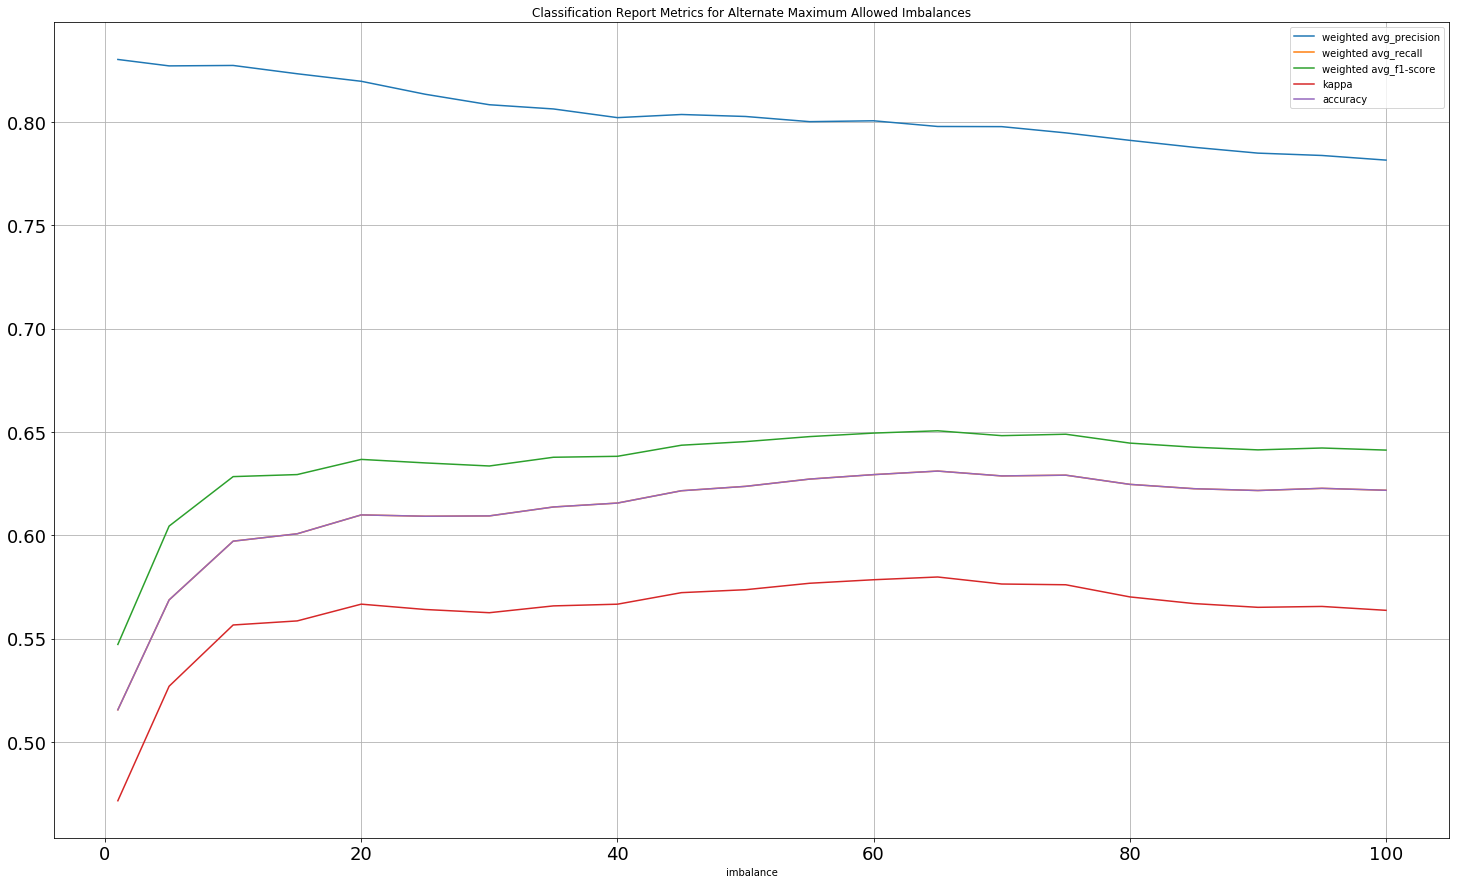

In [9]:
# Plot Data
title = 'Classification Report Metrics for Alternate Maximum Allowed Imbalances'
ycols = ['weighted avg_precision', 'weighted avg_recall', 'weighted avg_f1-score', 'kappa', 'accuracy']
imbstatsdf.plot.line(x='imbalance', y=ycols, figsize=(25, 15), title=title, grid=True, fontsize=18)

## Sample Exhaustion

In [19]:
def evaluate_sample_exhaustion(sample, nomenclature, prefix='code', step=10):
    cl = Classification()
    
    print(f'Loading {sample.name}...\n')
    featuresdf = cl.load_features(sample)
    
    for i, idf in cl.iterate_sample_exhaustion(featuresdf, step=step):
        print(f'Evaluating with minimum class sample count of {i}...')
    
        splits, featcols = cl.split_features(idf, prefix=prefix)    
        model, score = cl.evaluate_model(cl.get_model(), *splits)

        columns, labels, predictions = cl.model_behaviour(model, splits)
        report, true_matrix, pred_matrix = cl.classification_metrics(columns, labels, predictions, 
                                                                     splits, score)
        
        report['count'] = i

        cm_title = f'Confusion Matrix with max samples of {i}'
        cm_filename = f'exhaustion_{i:0>3}'
        cm_path = Path(sample.parent.parent, 'statistics', 'exhaustion', 'matrices', f'{cm_filename}.svg')
        cm = ConfusionMatrix(columns, nomenclature, report, true_matrix, pred_matrix, 
                             cm_path, title=cm_title, prefix=f'{prefix}_')
        
        yield report, true_matrix, pred_matrix, cm
        print()

In [ ]:
iiex = evaluate_sample_exhaustion(path['samples'][15], nomenclature, step=10)

exhaustion_evals = [eval_output for eval_output in iiex]

In [ ]:
# Flatten Report Values
exhaustion_reports = [i[0] for i in exhaustion_evals]
exhaustion_flattened_reports = [dict(flatten_dict(i)) for i in exhaustion_reports]

# Frame Data in Pandas
exhstatsdf = pd.DataFrame(exhaustion_flattened_reports)
exhstatsdf.to_parquet(Path(path['data'], 'exhaustion.parquet'))

In [10]:
exhstatsdf = pd.read_parquet(Path(path['data'].parent, 'statistics', 'exhaustion', 'exhaustion.parquet'))

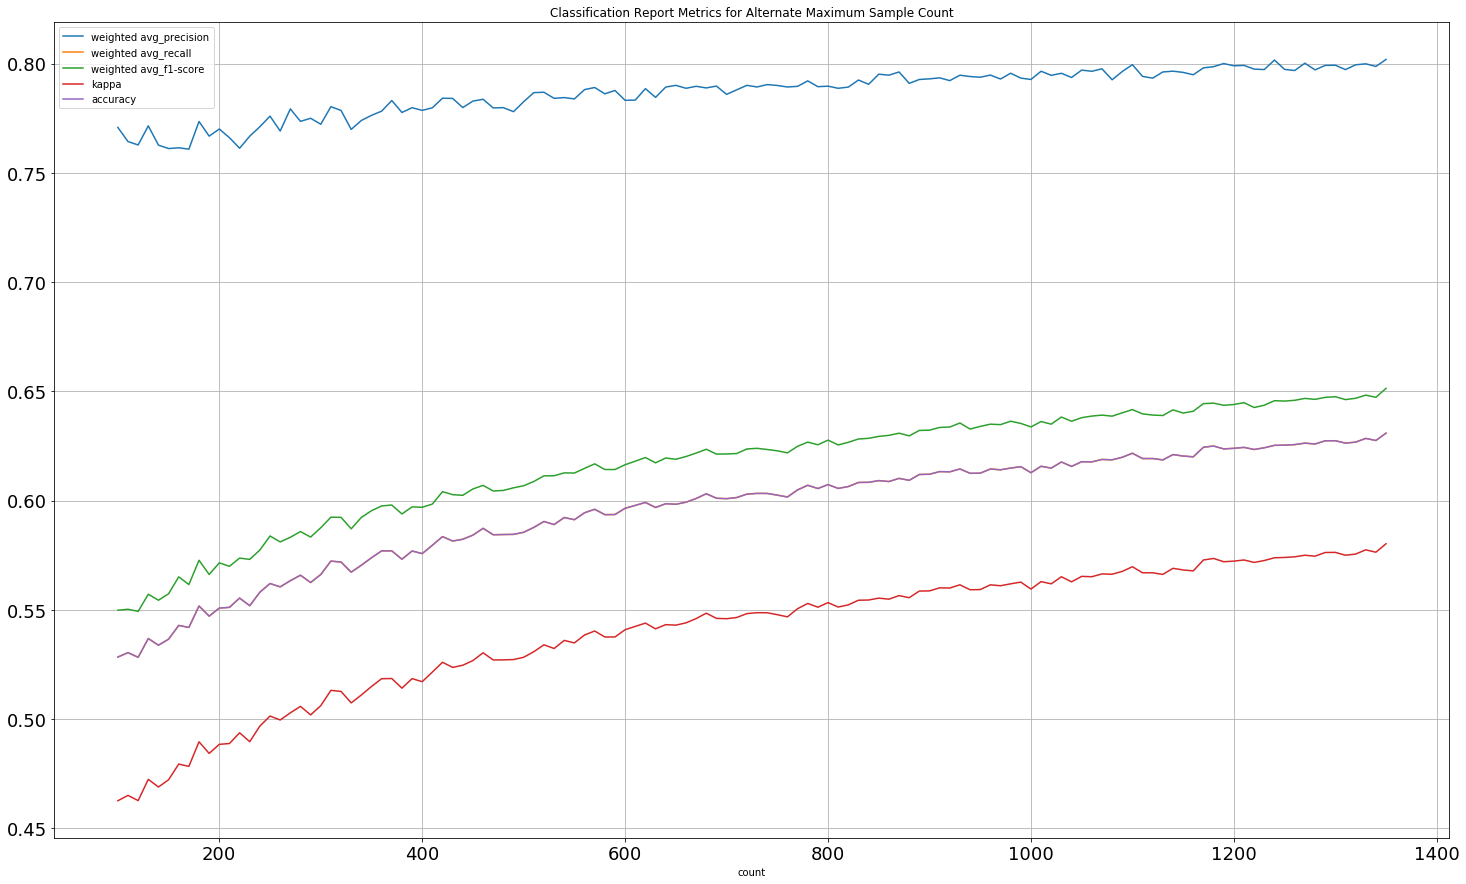

In [11]:
# Plot Data
title = 'Classification Report Metrics for Alternate Maximum Sample Count'
ycols = ['weighted avg_precision', 'weighted avg_recall', 'weighted avg_f1-score', 'kappa', 'accuracy']
exhstatsdf.plot.line(x='count', y=ycols, figsize=(25, 15), title=title, grid=True, fontsize=18)

## Exhaustion with Imbalance 20

In [21]:
iiex = evaluate_sample_exhaustion(path['samples'][9], nomenclature, step=10)

exhaustion_evals = [eval_output for eval_output in iiex]

Loading samples_20_random.parquet...

Evaluating with minimum class sample count of 100...
Test Size:	0.2
Split Shapes:	[(15137, 88), (3785, 88), (15137, 12), (3785, 12)]
Mean: 0.357 (Std: 0.018)

Evaluating with minimum class sample count of 110...
Test Size:	0.2
Split Shapes:	[(16651, 88), (4163, 88), (16651, 12), (4163, 12)]
Mean: 0.352 (Std: 0.014)

Evaluating with minimum class sample count of 120...
Test Size:	0.2
Split Shapes:	[(18164, 88), (4542, 88), (18164, 12), (4542, 12)]
Mean: 0.342 (Std: 0.012)

Evaluating with minimum class sample count of 130...
Test Size:	0.2
Split Shapes:	[(19679, 88), (4920, 88), (19679, 12), (4920, 12)]
Mean: 0.354 (Std: 0.019)

Evaluating with minimum class sample count of 140...
Test Size:	0.2
Split Shapes:	[(21192, 88), (5299, 88), (21192, 12), (5299, 12)]
Mean: 0.349 (Std: 0.010)

Evaluating with minimum class sample count of 150...
Test Size:	0.2
Split Shapes:	[(22706, 88), (5677, 88), (22706, 12), (5677, 12)]
Mean: 0.361 (Std: 0.003)

Evaluati

In [29]:
# Flatten Report Values
exhaustion_reports = [i[0] for i in exhaustion_evals]
exhaustion_flattened_reports = [dict(Classification().flatten_dict(i)) for i in exhaustion_reports]

# Frame Data in Pandas
exhstatsdf = pd.DataFrame(exhaustion_flattened_reports)
exhstatsdf.to_parquet(Path(path['data'].parent, 'statistics', 'exhaustion', 'exhaustion_20.parquet'))

In [30]:
exhstatsdf = pd.read_parquet(Path(path['data'].parent, 'statistics', 'exhaustion', 'exhaustion_20.parquet'))

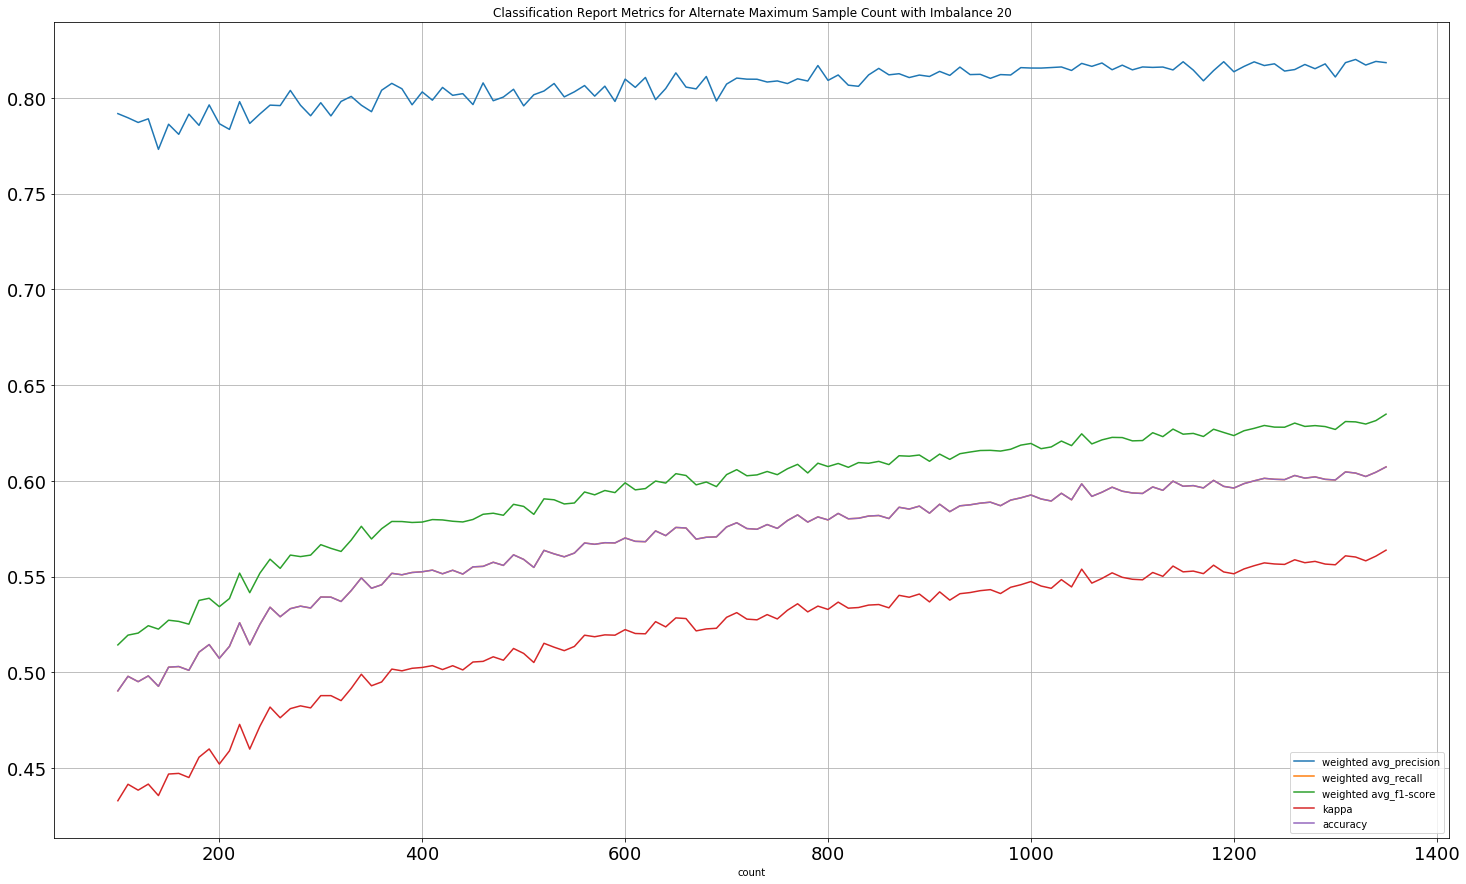

In [31]:
# Plot Data
title = 'Classification Report Metrics for Alternate Maximum Sample Count with Imbalance 20'
ycols = ['weighted avg_precision', 'weighted avg_recall', 'weighted avg_f1-score', 'kappa', 'accuracy']
exhstatsdf.plot.line(x='count', y=ycols, figsize=(25, 15), title=title, grid=True, fontsize=18)

## Downsample All Feature Set

In [9]:
from dask.distributed import Client

client = Client(processes=False)
client

<Client: 'inproc://10.120.43.32/97415/1' processes=1 threads=16, memory=64.42 GB>

In [10]:
import dask.dataframe as dd

path['allsamples'] = Path(path['root'], 'classification', 'features', 'samples', 'onetile', 'samples_100_random', 'samples_100_random.parquet')
path['downsample'] = Path(path['root'], 'classification', 'features', 'samples', 'onetile', 'downsample.parquet')

In [11]:
features = dd.read_parquet(path['allsamples'])
features

Dask DataFrame Structure:
                             code 01:Gray:Energy 01:Gray:Entropy 01:Gray:Correlation 01:Gray:Inverse Difference Moment 01:Gray:Inertia 01:Gray:Cluster Shade 01:Gray:Cluster Prominence 01:Gray:Haralick Correlation 01:Gray:LBP:1 01:Gray:LBP:2 01:Gray:LBP:3 01:Gray:LBP:4 01:Gray:LBP:5 01:Gray:LBP:6 01:Gray:LBP:7 01:Gray:LBP:8 01:Gray:LBP:9 01:Gray:LBP:10 01:Gray:LBP:11 01:Gray:LBP:12 01:Gray:LBP:13 01:Gray:LBP:14 01:Gray:LBP:15 01:Gray:Mean:2 01:Gray:Variance:2 01:Gray:Skewness:2 01:Gray:Kurtosis:2 01:Gray:Mean:3 01:Gray:Variance:3 01:Gray:Skewness:3 01:Gray:Kurtosis:3 01:Vegetation:NDVI 01:Water:NDWI 01:Soil:BI2 01:Vegetation:NDRE 01:NDVI:Energy 01:NDVI:Entropy 01:NDVI:Correlation 01:NDVI:Inverse Difference Moment 01:NDVI:Inertia 01:NDVI:Cluster Shade 01:NDVI:Cluster Prominence 01:NDVI:Haralick Correlation 01:NDWI:Energy 01:NDWI:Entropy 01:NDWI:Correlation 01:NDWI:Inverse Difference Moment 01:NDWI:Inertia 01:NDWI:Cluster Shade 01:NDWI:Cluster Prominence 01:NDWI:Haralick Correlation 01:BI2:Energy 01:BI2:Entropy 01:BI2:Correlation 01:BI2:Inverse Difference Moment 01:BI2:Inertia 01:BI2:Cluster Shade 01:BI2:Cluster Prominence 01:BI2:Haralick Correlation 01:NDRE:Energy 01:NDRE:Entropy 01:NDRE:Correlation 01:NDRE:Inverse Difference Moment 01:NDRE:Inertia 01:NDRE:Cluster Shade 01:NDRE:Cluster Prominence 01:NDRE:Haralick Correlation 01:NDVI:LBP:1 01:NDVI:LBP:2 01:NDVI:LBP:3 01:NDVI:LBP:4 01:NDVI:LBP:5 01:NDVI:LBP:6 01:NDVI:LBP:7 01:NDVI:LBP:8 01:NDVI:LBP:9 01:NDVI:LBP:10 01:NDVI:LBP:11 01:NDVI:LBP:12 01:NDVI:LBP:13 01:NDVI:LBP:14 01:NDVI:LBP:15 01:NDWI:LBP:1 01:NDWI:LBP:2 01:NDWI:LBP:3 01:NDWI:LBP:4 01:NDWI:LBP:5 01:NDWI:LBP:6 01:NDWI:LBP:7 01:NDWI:LBP:8 01:NDWI:LBP:9 01:NDWI:LBP:10 01:NDWI:LBP:11 01:NDWI:LBP:12 01:NDWI:LBP:13 01:NDWI:LBP:14 01:NDWI:LBP:15 01:BI2:LBP:1 01:BI2:LBP:2 01:BI2:LBP:3 01:BI2:LBP:4 01:BI2:LBP:5 01:BI2:LBP:6 01:BI2:LBP:7 01:BI2:LBP:8 01:BI2:LBP:9 01:BI2:LBP:10 01:BI2:LBP:11 01:BI2:LBP:12 01:BI2:LBP:13 01:BI2:LBP:14 01:BI2:LBP:15 01:NDRE:LBP:1 01:NDRE:LBP:2 01:NDRE:LBP:3 01:NDRE:LBP:4 01:NDRE:LBP:5 01:NDRE:LBP:6 01:NDRE:LBP:7 01:NDRE:LBP:8 01:NDRE:LBP:9 01:NDRE:LBP:10 01:NDRE:LBP:11 01:NDRE:LBP:12 01:NDRE:LBP:13 01:NDRE:LBP:14 01:NDRE:LBP:15 01:NDVI:Mean:2 01:NDVI:Variance:2 01:NDVI:Skewness:2 01:NDVI:Kurtosis:2 01:NDVI:Mean:3 01:NDVI:Variance:3 01:NDVI:Skewness:3 01:NDVI:Kurtosis:3 01:NDWI:Mean:2 01:NDWI:Variance:2 01:NDWI:Skewness:2 01:NDWI:Kurtosis:2 01:NDWI:Mean:3 01:NDWI:Variance:3 01:NDWI:Skewness:3 01:NDWI:Kurtosis:3 01:BI2:Mean:2 01:BI2:Variance:2 01:BI2:Skewness:2 01:BI2:Kurtosis:2 01:BI2:Mean:3 01:BI2:Variance:3 01:BI2:Skewness:3 01:BI2:Kurtosis:3 01:NDRE:Mean:2 01:NDRE:Variance:2 01:NDRE:Skewness:2 01:NDRE:Kurtosis:2 01:NDRE:Mean:3 01:NDRE:Variance:3 01:NDRE:Skewness:3 01:NDRE:Kurtosis:3 01:vh_asc 01:vv_asc 01:vh_des 01:vv_des 01:B2:Blue:490 01:B3:Green:560 01:B4:Red:670 01:B5:Vegetation red edge:705 01:B6:Vegetation red edge:740 01:B7:Vegetation red edge:780 01:B8:NIR:820 01:B8A:Narrow NIR:865 01:B11:SWIR:1650 01:B12:SWIR:2200 01:vh_asc:Energy 01:vh_asc:Entropy 01:vh_asc:Correlation 01:vh_asc:Inverse Difference Moment 01:vh_asc:Inertia 01:vh_asc:Cluster Shade 01:vh_asc:Cluster Prominence 01:vh_asc:Haralick Correlation 01:vv_asc:Energy 01:vv_asc:Entropy 01:vv_asc:Correlation 01:vv_asc:Inverse Difference Moment 01:vv_asc:Inertia 01:vv_asc:Cluster Shade 01:vv_asc:Cluster Prominence 01:vv_asc:Haralick Correlation 01:vh_des:Energy 01:vh_des:Entropy 01:vh_des:Correlation 01:vh_des:Inverse Difference Moment 01:vh_des:Inertia 01:vh_des:Cluster Shade 01:vh_des:Cluster Prominence 01:vh_des:Haralick Correlation 01:vv_des:Energy 01:vv_des:Entropy 01:vv_des:Correlation 01:vv_des:Inverse Difference Moment 01:vv_des:Inertia 01:vv_des:Cluster Shade 01:vv_des:Cluster Prominence 01:vv_des:Haralick Correlation 01:SAR:VH/VV_ASC 01:SAR:RVI_ASC 01:SAR:VH/VV_DES 01:SAR:RVI_DES 01:vh_asc:LBP:1 01:vh_asc:LBP:2 01:vh_asc:LBP:3 01:vh_asc:LBP:4 01:vh_asc:LBP:5 01:vh_asc:LBP:6 01:vh_asc:LBP:7 01:vh_asc:L

In [12]:
szdf = features.groupby(by='code').size().compute()
mincount = szdf.min()
codes = features.code.compute().unique().to_list()

def dask_resample_class(code, features=features, sizedf=szdf, mincount=mincount, limcount=400, imbalance=20.0, random_state=42):    
    cgrp = features[features.code == code].dropna()
    
    count = sizedf.loc[code]
    minratio = count/mincount
    limratio = limcount/count
    
    frac = limratio * min(minratio, imbalance)
    if frac < 1.0:
        return cgrp.sample(frac=frac, random_state=random_state)
    
    return cgrp

szdf, mincount, codes

(code
 25    135200
 3     135200
 30     85122
 9     135200
 7      87058
 17    135200
 12    135200
 20     14305
 23      8938
 11     27472
 18      1352
 6      14926
 dtype: int64,
 1352,
 [25, 3, 30, 9, 7, 17, 12, 20, 23, 11, 18, 6])

In [16]:
szdf.sum()

915173

In [13]:
downfeatures = dd.concat([dask_resample_class(c) for c in codes]).compute()
downfeatures.to_parquet(path['downsample'])
downfeatures

code  01:Gray:Energy  01:Gray:Entropy  01:Gray:Correlation  \
1363     25             1.0              0.0                  0.0   
3        25             1.0              0.0                  0.0   
23       25             1.0              0.0                  0.0   
1347     25             1.0              0.0                  0.0   
37       25             1.0              0.0                  0.0   
...     ...             ...              ...                  ...   
675226    6             1.0              0.0                  0.0   
673618    6             1.0              0.0                  0.0   
674574    6             1.0              0.0                  0.0   
674482    6             1.0              0.0                  0.0   
674946    6             1.0              0.0                  0.0   

        01:Gray:Inverse Difference Moment  01:Gray:Inertia  \
1363                                  1.0              0.0   
3                                     1.0              0.0   
23                                    1.0              0.0   
1347                                  1.0              0.0   
37                                    1.0              0.0   
...                                   ...              ...   
675226                                1.0              0.0   
673618                                1.0              0.0   
674574                                1.0              0.0   
674482                                1.0              0.0   
674946                                1.0              0.0   

        01:Gray:Cluster Shade  01:Gray:Cluster Prominence  \
1363                      0.0                         0.0   
3                         0.0                         0.0   
23                        0.0                         0.0   
1347                      0.0                         0.0   
37                        0.0                         0.0   
...                       ...                         ...   
675226                    0.0                         0.0   
673618                    0.0                         0.0   
674574                    0.0                         0.0   
674482                    0.0                         0.0   
674946                    0.0                         0.0   

        01:Gray:Haralick Correlation  01:Gray:LBP:1  ...  \
1363                       -0.035714              9  ...   
3                          -0.035714              7  ...   
23                         -0.035714              6  ...   
1347                       -0.035714              8  ...   
37                         -0.035714              1  ...   
...                              ...            ...  ...   
675226                    750.857117              3  ...   
673618                    270.285706              4  ...   
674574                    480.535706              4  ...   
674482                    480.535706              2  ...   
674946                    270.285706              0  ...   

        12:vh_des:Skewness:3  12:vh_des:Kurtosis:3  12:vv_des:Mean:2  \
1363                0.769883              0.457814          0.108882   
3                   0.676402             -0.328795          0.093275   
23                 -0.185375             -1.060173          0.106405   
1347                0.116075             -0.686041          0.100705   
37                  0.553679             -0.233740          0.146264   
...                      ...                   ...               ...   
675226             -0.003918             -1.405372          0.110785   
673618             -0.299286             -0.827543          0.095442   
674574             -0.744399              0.193781          0.153867   
674482              0.679530              1.121440          0.095237   
674946             -0.040225              0.388431          0.119667   

        12:vv_des:Variance:2  12:vv_des:Skewness:2  12:vv_des:Kurtosis:2  \
1363                0.000095          

In [14]:
downszdf = downfeatures.groupby(by='code').size()
downszdf

code
25    7966
3     7950
30    7967
9     7991
7     7858
17    7979
12    7949
20    4234
23    2644
11    7956
18     400
6     4416
dtype: int64

In [15]:
downszdf.sum()

75310